<font size="8"> **Accessing bathymetry data from the ACCESS-OM2-01 model** </font>  
Depth of the water column and bottom slope have been identified as environmental variables that influence the habitat preference of crabeater seals (*Lobodon carcinophagus*). In this notebook, we will extract the maximum depth and calculate the bottom slope for each grid cell in the ACCESS-OM2-01 model over the Southern Ocean.  
  
The bathymetry in the ACCESS-OM2-01 model was based on the [General Bathymetric Chart of the Oceans (GEBCO)](https://www.gebco.net/data_and_products/gridded_bathymetry_data/) dataset from 2014, which had an original horizontal resolution of 30 arc seconds ($\sim 0.01^{\circ}$). In this notebook, we are using the GEBCO dataset that was regridded to match the resolution of the ACCESS-OM2-01 model ($0.1^{\circ}$).

# Setting working directory
In order to ensure these notebooks work correctly, we will set the working directory. We assume that you have saved a copy of this repository in your home directory (represented by `~` in the code chunk below). If you have saved this repository elsewhere in your machine, you need to ensure you update this line with the correct filepath where you saved these notebooks.

In [1]:
import os
os.chdir(os.path.expanduser('~/Chapter2_Crabeaters/Scripts'))

# Loading modules

In [2]:
#Accessing model data
import intake
#Useful functions
import UsefulFunctions as uf
#Dealing with data
import xarray as xr
import numpy as np
#Data visualisation
import matplotlib.pyplot as plt
#Spatial analysis
from xrspatial import slope
import rioxarray

# Loading ACCESS-OM2-01 data
The regridded GEBCO bathymetry data does not have latitude and longitude values; it only has indices. This represents an issue as we need coordinates to be able to extract depth and bottom slope data at the points where seals have been recorded.  
  
However, since the GEBCO data was regridded to match ACCESS-OM2-01 grid, we can correct this issue easily by assigning the latitude and longitude values from the model outputs. Here we will load the `area_t` variable, which has the area of each grid cell in the model. We will use the values in the `yt_ocean` and `xt_ocean` dimensions, which include the latitude and longitude values for the centre of each grid cell.

In [3]:
#Starting cookbook session to search for area data
catalog = intake.cat.access_nri
#Load area data
area = catalog['01deg_jra55v140_iaf_cycle4'].search(variable = 'area_t').to_dask()['area_t']
#Check results
area

<xarray.DataArray 'area_t' (yt_ocean: 2700, xt_ocean: 3600)>
dask.array<open_dataset-a3dcdada652a62056900287409cd22dcarea_t, shape=(2700, 3600), dtype=float32, chunksize=(540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Attributes:
    long_name:     tracer cell area
    units:         m^2
    valid_range:   [0.e+00 1.e+15]
    cell_methods:  time: point
    coordinates:   geolon_t geolat_t
    ncfiles:       ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_j...
    contact:       Andrew Kiss
    email:         andrew.kiss@anu.edu.au
    created:       2022-04-27
    description:   0.1 degree ACCESS-OM2 global model configuration under int...
    notes:         Run configuration and history: https://github.com/COSIMA/0...

# Loading regridded GEBCO bathymetry file
We will load the regridded GEBCO bathymetry that was used to create the bathymetry for the ACCESS-OM2-01 model.

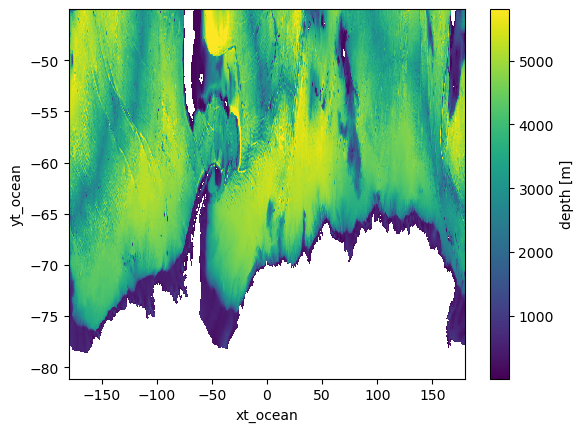

In [5]:
#Loading data
bathy = xr.open_dataarray('/g/data/ik11/inputs/access-om2/input_20201102/mom_01deg/topog.nc')

#Assigning coordinate values to replace indices
bathy.coords['xx'] = area['xt_ocean'].values
bathy.coords['yy'] = area['yt_ocean'].values

#Rename coordinate variables so they match model data and subsetting the Southern Ocean
bathy = bathy.rename(({'xx':'xt_ocean', 'yy':'yt_ocean'})).sel(yt_ocean = slice(-90, -45))

#Ensuring longitude values range between +/-180
bathy = uf.corrlong(bathy)

#Checking results
bathy.plot()

## Saving bathymetry file as netcdf

In [25]:
base_folder = '/g/data/v45/la6889/Chapter2_Crabeaters/Static_Variables/'
bathy.to_netcdf(os.path.join(base_folder, 'bathy_GEBCO_2D.nc'))

# Calculating bottom slope
The slope also known as inclination or gradient refers to the rise and fall of the terrain (i.e., seafloor). The slope was identified as a variable influencing habitat preference of crabeater seals. The reason behind its influence could be because it drives and modifies the energy and direction of water masses, which in turn can influence the distribution of nutrients in the water column and this in turn affects the distribution of primary and secondary production.

We will use the `xarray_spatial` library to calculate the bottom slope (in degrees) from the bathymetry data. 

In [13]:
bathy_slope = slope(bathy)

## Fixing metadata in bottom slope file
Changing the units and variable name in the data array before saving.

In [22]:
bathy_slope = bathy_slope.assign_attrs({'long_name': 'slope',
                                        'units': 'degrees'})
bathy_slope

<xarray.DataArray 'slope' (yt_ocean: 740, xt_ocean: 3600)>
dask.array<_trim, shape=(740, 3600), dtype=float64, chunksize=(540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -45.18 -45.11 -45.04
Attributes:
    long_name:                   slope
    units:                       degrees
    minimum_depth:               10.43281
    minimum_levels:              7
    min_thick:                   1.0
    min_frac:                    0.2
    nonadvective_cells_removed:  yes
    lakes_removed:               yes
    name:                        slope

## Plotting results

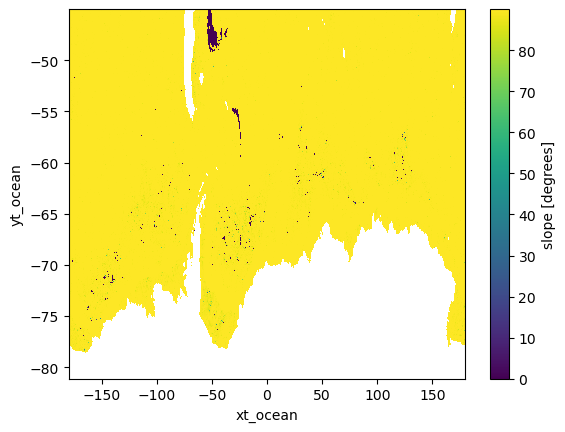

In [23]:
bathy_slope.plot()

## Saving results as netcdf

In [26]:
bathy_slope.to_netcdf(os.path.join(base_folder, 'bathy_slope_GEBCO_2D.nc'))